# DNN

In [1]:
# !pip install torchmetrics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# !pip install torchmetrics
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

In [4]:
df = pd.read_csv('./landslides_with_variables_cleaned.csv').drop(columns=['ID'])
df.head()

,Valid Landslide,Latitude,Longitude,CURVATURE,TWI,SLOPE_deg,DEM,SLOPE_deg.1,ASPECT_deg,LANDCOVER_CODE,ASPECT_rad,ASPECT_sin,ASPECT_cos,SLOPE_rad
0,1,-36.819859,174.746298,1.379645,5.286413,11.441814,18.809872,11.441814,222.978638,1.0,3.891711,-0.681726,-0.731608,0.199697
1,1,-36.798134,174.684934,0.190541,6.555068,14.671361,19.514647,14.671361,166.090866,1.0,2.898832,0.240383,-0.970678,0.256064
2,1,-36.932751,174.744548,0.068507,9.921234,17.020342,22.542194,17.020342,158.192902,11.0,2.760987,0.371483,-0.928440,0.297061
3,1,-36.852885,174.792092,0.528753,3.760681,29.180260,24.194622,29.180260,59.103947,11.0,1.031558,0.858100,0.513482,0.509292
4,1,-36.809204,174.718141,-0.087607,5.854521,15.388130,69.367027,15.388130,57.325916,1.0,1.000526,0.841755,0.539860,0.268574


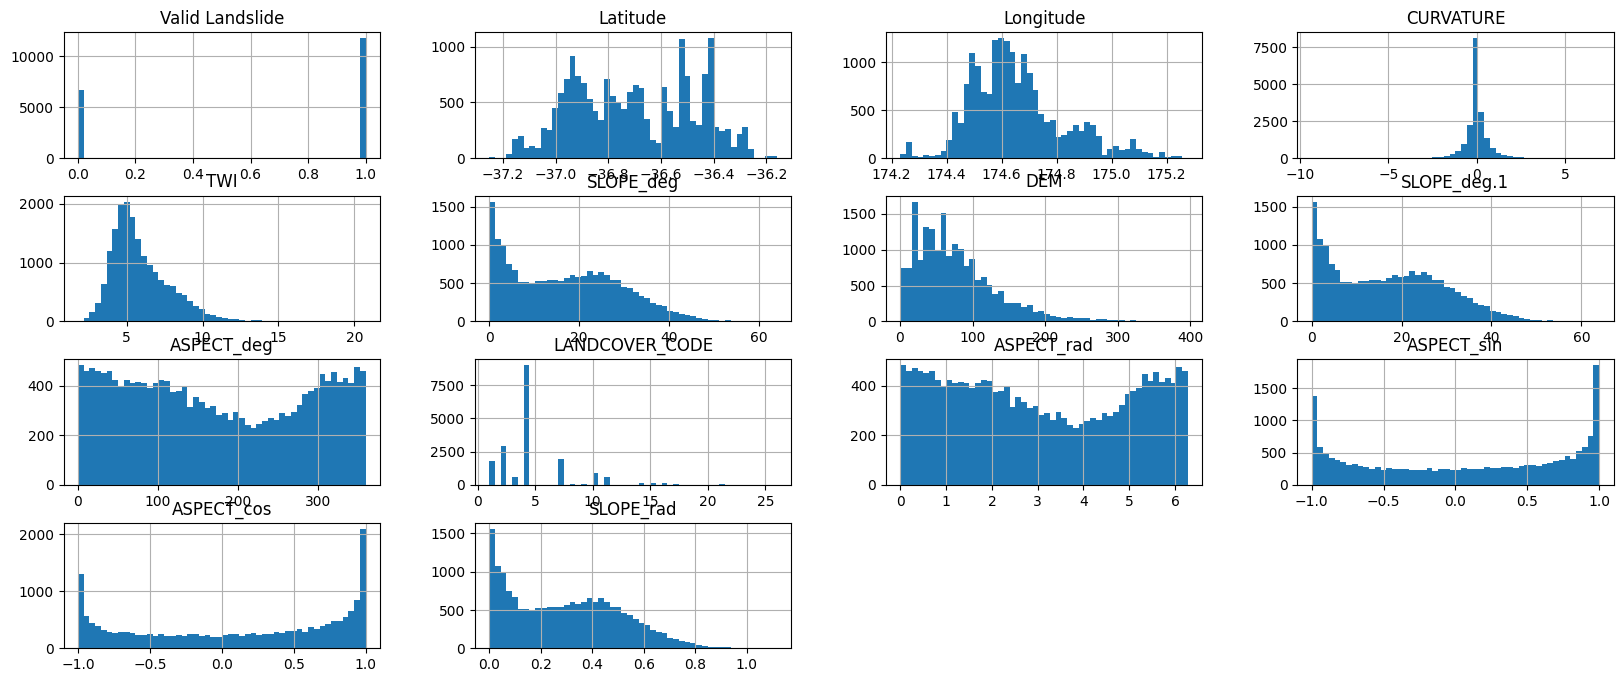

In [5]:
df.hist(bins=50, figsize=(20, 8))
plt.show()

## Spliting

In [6]:
# 1. Separate features (X) and target (y)
df['LANDCOVER_CODE'] = df['LANDCOVER_CODE'].astype(str)

X = df.drop("Valid Landslide", axis=1)
y = df["Valid Landslide"].copy()

# 2. Split data into training and testing sets
# 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=random_seed, stratify=y_train)


## Data Processing Pipeline

In [7]:
# Define pipelines
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

num_pipeline = make_pipeline(
    StandardScaler())

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

set_config(display='diagram')
preprocessing

,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [8]:
# 3. Fit the preprocessor on the training data ONLY
X_train_prepared = preprocessing.fit_transform(X_train)

# 4. Transform the validation and test data
X_valid_prepared = preprocessing.transform(X_valid)
X_test_prepared = preprocessing.transform(X_test)



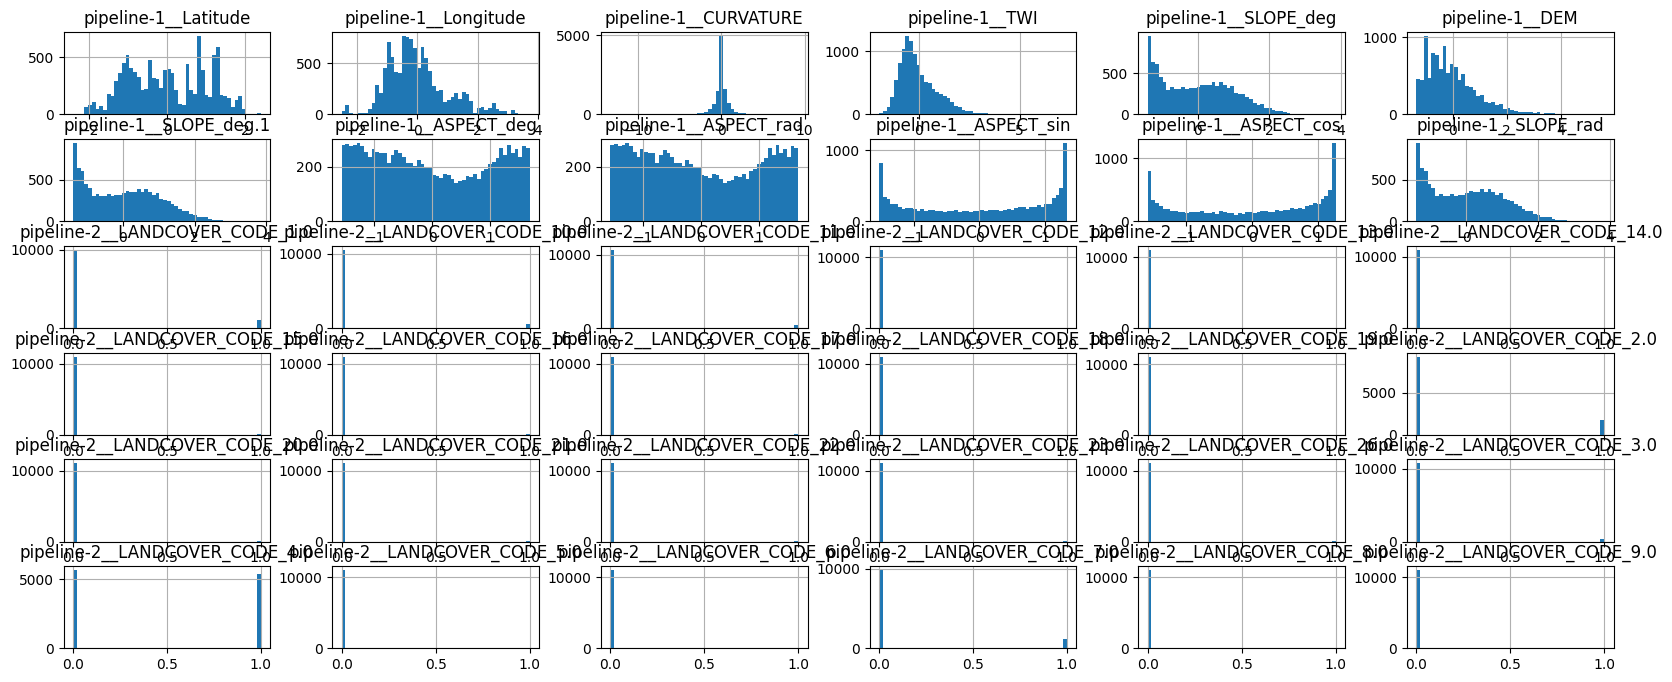

In [ ]:
# (Optional) Display the transformed training data
df_prepared = pd.DataFrame(X_train_prepared,
                           columns=preprocessing.get_feature_names_out(),
                           index=X_train.index)

df_prepared.hist(bins=50, figsize=(20, 8))
plt.show()